จัดทำโดย 
ณัชณศา เลิศมหากูล 65340500021
ด.ช.อนวัช อนุสุเรนทร์ 65340500056
ชัญญาภัค ทรัพย์สวัสดิ์กุล 65340500067

Import library

In [63]:
from ucimlrepo import fetch_ucirepo 
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import shutil
import math
import os
from sklearn.preprocessing import MinMaxScaler


Import Data

In [2]:
# Fetch dataset 
support2 = fetch_ucirepo(id=880) 

X = support2.data.features 
y = support2.data.targets 

# Combine features and targets into a single DataFrame, if desired
df = pd.concat([X, y], axis=1)

# Save to CSV
# df.to_csv('output.csv', index=False)
# Move the file to a location where it can be accessed/downloaded
# shutil.move('output.csv', 'csv')

# metadata 
print(support2.metadata) 

# variable information 
print(support2.variables)

df = pd.read_csv('data.csv', header = None)
df.columns = ['id','age','death','sex','hospdead','slos','d.time','dzgroup','dzclass','num.co','edu','income','scoma','charges','totcst','totmcst','avtisst','race','sps','aps','surv2m','surv6m','hday','diabetes','dementia','ca','prg2m','prg6m','dnr','dnrday','meanbp','wblc','hrt','resp','temp','pafi','alb','bili','crea','sod','ph','glucose','bun','urine','adlp','adls','sfdm2','adlsc']
num_columns = len(df.columns)
print(f"จำนวนคอลัมน์ทั้งหมด: {num_columns}")
df.head()


{'uci_id': 880, 'name': 'SUPPORT2', 'repository_url': 'https://archive.ics.uci.edu/dataset/880/support2', 'data_url': 'https://archive.ics.uci.edu/static/public/880/data.csv', 'abstract': "This dataset comprises 9105 individual critically ill patients across 5 United States medical centers, accessioned throughout 1989-1991 and 1992-1994.\nEach row concerns hospitalized patient records who met the inclusion and exclusion criteria for nine disease categories: acute respiratory failure, chronic obstructive pulmonary disease, congestive heart failure, liver disease, coma, colon cancer, lung cancer, multiple organ system failure with malignancy, and multiple organ system failure with sepsis. The goal is to determine these patients' 2- and 6-month survival rates based on several physiologic, demographics, and disease severity information. \nIt is an important problem because it addresses the growing national concern over patients' loss of control near the end of life. It enables earlier deci

id       age  death     sex  hospdead  slos  d.time      dzgroup  \
0  id       age  death     sex  hospdead  slos  d.time      dzgroup   
1   1  62.84998      0    male         0     5    2029  Lung Cancer   
2   2  60.33899      1  female         1     4       4    Cirrhosis   
3   3  52.74698      1  female         0    17      47    Cirrhosis   
4   4  42.38498      1  female         0     3     133  Lung Cancer   

              dzclass  num.co  ...        crea  sod        ph  glucose  bun  \
0             dzclass  num.co  ...        crea  sod        ph  glucose  bun   
1              Cancer       0  ...  1.19995117  141  7.459961      NaN  NaN   
2  COPD/CHF/Cirrhosis       2  ...         5.5  132      7.25      NaN  NaN   
3  COPD/CHF/Cirrhosis       2  ...           2  134  7.459961      NaN  NaN   
4              Cancer       2  ...  0.79992676  139       NaN      NaN  NaN   

   urine  adlp  adls                sfdm2  adlsc  
0  urine  adlp  adls                sfdm2  adlsc  
1    NaN     7     7                  NaN      7  
2    NaN   NaN     1     <2 mo. follow-up      1  
3    NaN     1     0     <2 mo. follow-up      0  
4    NaN     0     0  no(M2 and SIP pres)      0  

[5 rows x 48 columns]

กำหนด Taget variable

In [3]:
# Define Target variable
target_variable = pd.to_numeric(df['charges'], errors='coerce')

Cleaning Data

ตัด column ที่มี missing value มากกว่า 40% และตัด row ที่มี missing value มากกว่า 30% เพราะปริมาณข้อมูลที่สูญหายมากเกินไป จึงไม่สามารถใช้วิธีนำมาเติม Missing Value ได้

In [3]:
# เก็บจำนวนคอลัมน์และแถวก่อนการลบ
cols_before = df.columns
rows_before = df.shape[0]

# ลบคอลัมน์ที่มีค่าหายไปมากกว่า 40%
df = df.loc[:, df.isnull().mean() < 0.4]
cols_after = df.columns

# ลบแถวที่มีค่าหายไปมากกว่า 30%
df = df.dropna(thresh=len(df.columns) * 0.7)
rows_after = df.shape[0]

# คำนวณจำนวนคอลัมน์ที่ถูกลบออก
cols_dropped = set(cols_before) - set(cols_after)

# คำนวณจำนวนแถวที่ถูกลบ
rows_dropped = rows_before - rows_after

# แสดงผลลัพธ์
print("cols_before : ",cols_before)
print("cols_After : ",cols_after)
print("คอลัมน์ที่ถูกลบ:")
print(cols_dropped)
print("\nคอลัมน์ที่ยังคงอยู่:")
print(df.columns)
print(f"\nจำนวนแถวที่ถูกลบ: {rows_dropped}")
print("\nข้อมูลตัวอย่างหลังการลบ:")
#ปริ้นตารางมาเช็ค
df.head()


cols_before :  Index(['id', 'age', 'death', 'sex', 'hospdead', 'slos', 'd.time', 'dzgroup',
       'dzclass', 'num.co', 'edu', 'income', 'scoma', 'charges', 'totcst',
       'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday',
       'diabetes', 'dementia', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea',
       'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp', 'adls', 'sfdm2',
       'adlsc'],
      dtype='object')
cols_After :  Index(['id', 'age', 'death', 'sex', 'hospdead', 'slos', 'd.time', 'dzgroup',
       'dzclass', 'num.co', 'edu', 'income', 'scoma', 'charges', 'totcst',
       'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday',
       'diabetes', 'dementia', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea',
       'sod', 'ph', 'adls', 'sfdm2', 'adlsc'],
      dtype='object')
คอลัมน์ที่ถูกลบ:
{'urine', 

id       age  death     sex  hospdead  slos  d.time      dzgroup  \
0  id       age  death     sex  hospdead  slos  d.time      dzgroup   
1   1  62.84998      0    male         0     5    2029  Lung Cancer   
2   2  60.33899      1  female         1     4       4    Cirrhosis   
3   3  52.74698      1  female         0    17      47    Cirrhosis   
4   4  42.38498      1  female         0     3     133  Lung Cancer   

              dzclass  num.co  ...      temp       pafi        alb  \
0             dzclass  num.co  ...      temp       pafi        alb   
1              Cancer       0  ...        36        388  1.7998047   
2  COPD/CHF/Cirrhosis       2  ...  34.59375         98        NaN   
3  COPD/CHF/Cirrhosis       2  ...  37.39844  231.65625        NaN   
4              Cancer       2  ...        35        NaN        NaN   

         bili        crea  sod        ph  adls                sfdm2  adlsc  
0        bili        crea  sod        ph  adls                sfdm2  adlsc  
1  0.19998169  1.19995117  141  7.459961     7                  NaN      7  
2         NaN         5.5  132      7.25     1     <2 mo. follow-up      1  
3  2.19970703           2  134  7.459961     0     <2 mo. follow-up      0  
4         NaN  0.79992676  139       NaN     0  no(M2 and SIP pres)      0  

[5 rows x 44 columns]

Change to Numeric 

เปลี่ยน data ที่ยังเป็น type อื่นที่ไม่ใช่  numeric ให้เป็น numeric เพื่อสามารถใช้งานร่วมกันกับ Target ได้

In [4]:
#เลือก Column ที่มั่นใจว่าไม่ใช่ Numeric
categorical_columns = ['sex','income','race','ca', 'dzgroup', 'dzclass', 'dnr' , 'sfdm2'] 
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder() # ใช้การ Encoder ในการแปลง
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
print(f"Categorical columns: {categorical_columns}")
df[categorical_columns].head()

Categorical columns: ['sex', 'income', 'race', 'ca', 'dzgroup', 'dzclass', 'dnr', 'sfdm2']


sex  income  race  ca  dzgroup  dzclass  dnr  sfdm2
0    2       3     5   0        8        4    0      6
1    1       0     4   1        6        2    4      4
2    0       0     6   2        3        1    3      0
3    0       5     6   2        3        1    4      0
4    0       5     6   1        6        2    4      5

แปลง data ที่เป็น string ของตัวเลขให้เป็น numeric 

In [5]:
# แปลงคอลัมน์ที่ควรเป็นตัวเลขทั้งหมด
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # แปลงเป็นตัวเลข ถ้าไม่สามารถแปลงได้จะกลายเป็น NaN


Missing Value 

จัดการข้อมูลที่หายไปโดยหา method ที่ดีที่สุดของแต่ละคอลัมมาเติม Missing value 
- mean
- mode
- hot-deck
- Nearest Neighbor
- Regression(ใช้ไม่ได้เพราะทุกแถวมี Missing value หมดจึงหาแถวที่สมบูรณ์มาเทียบไม่ได้)


In [6]:
# ฟังก์ชันสำหรับ hot-deck imputation (ใช้ KNN)
def hot_deck_imputation(X_train, X_test):
    imputer = KNNImputer(n_neighbors=5)
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    return X_train_imputed, X_test_imputed

In [7]:
def evaluate_imputation(method, df, target_col='charges'):
    # แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    
    X_train = df_train.drop(columns=[target_col])
    y_train = df_train[target_col]
    
    X_test = df_test.drop(columns=[target_col])
    y_test = df_test[target_col]
    
    # Handle missing values in the target variable
    y_train = pd.to_numeric(y_train, errors='coerce')  # แปลงให้เป็นตัวเลข
    y_test = pd.to_numeric(y_test, errors='coerce')

    y_train = y_train.fillna(y_train.mean())
    y_test = y_test.fillna(y_test.mean())
    
    if method == 'mean':
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

    elif method == 'mode':
        imputer = SimpleImputer(strategy='most_frequent')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
    elif method == 'hot_deck':
        # Hot-deck Imputation (Using KNN)
        X_train_imputed, X_test_imputed = hot_deck_imputation(X_train, X_test)
    
    elif method == 'nearest_neighbor':
        # Nearest Neighbor (KNNImputer)
        imputer = KNNImputer(n_neighbors=5)
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

    else:
        raise ValueError(f"Unknown method: {method}")

    # Train a Linear Regression model
    model = LinearRegression()
    model.fit(X_train_imputed, y_train)
    
    # Predict and calculate MSE
    y_pred = model.predict(X_test_imputed)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

หา method ที่ดีที่สุดในการเติม missing value โดยดูจากค่า MSE ที่ต่ำที่สุด

In [50]:
# รายการวิธีการที่จะทดสอบ 
methods = ['mean', 'mode', 'hot_deck', 'nearest_neighbor']
results = {}

# สร้างสำเนาข้อมูลเพื่อเติมค่า
df_filled = df.copy()

for col in df.columns:
    print(f"\nTesting column: {col}")
    results[col] = {}

    # วนลูปทดสอบแต่ละวิธีการเติมค่าที่หายไป
    for method in methods:
        try:
            print(f"  Method: {method}")
            mse = evaluate_imputation(method, df, target_col=col)
            results[col][method] = mse
            print(f"    MSE: {mse}")
        except ValueError as e:
            print(f"    Error with method {method}: {e}")

    # หาวิธีที่ดีที่สุดที่มีค่า MSE ต่ำที่สุด
    best_method = min(results[col], key=results[col].get)
    print(f"Best method for {col}: {best_method}")

    # เติมค่า Missing Value ใน df_filled สำหรับคอลัมน์นั้นด้วยวิธีที่ดีที่สุด
    if best_method == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif best_method == 'mode':
        imputer = SimpleImputer(strategy='most_frequent')
    elif best_method == 'hot_deck':
        imputer = KNNImputer(n_neighbors=5)
    elif best_method == 'nearest_neighbor':
        imputer = KNNImputer(n_neighbors=5)

    # เติมค่าในคอลัมน์นั้นๆ
    df_filled[col] = df_filled[col].mask(df_filled[col].isna(), imputer.fit_transform(df[[col]]).flatten())

# บันทึกผลลัพธ์ลงในไฟล์ CSV
output_file = 'filled_data.csv'
df_filled.to_csv(output_file, index=False)
shutil.move('filled_data.csv', 'csv')
print(f"\nCompleted filling missing values. Results saved to {output_file}")


Testing column: id
  Method: mean
    MSE: 5248006.0483458815
  Method: mode
    MSE: 5065993.869988904
  Method: hot_deck
    MSE: 5306560.117732769
  Method: nearest_neighbor
    MSE: 5306560.117732769
Best method for id: mode

Testing column: age
  Method: mean
    MSE: 128.08762350494794
  Method: mode
    MSE: 128.5494661195713
  Method: hot_deck
    MSE: 128.09611571880808
  Method: nearest_neighbor
    MSE: 128.09611571880808
Best method for age: mean

Testing column: death
  Method: mean
    MSE: 0.09636628484034378
  Method: mode
    MSE: 0.09518936280582553
  Method: hot_deck
    MSE: 0.09564997411402323
  Method: nearest_neighbor
    MSE: 0.09564997411402323
Best method for death: mode

Testing column: sex
  Method: mean
    MSE: 0.24142530756384056
  Method: mode
    MSE: 0.24155892417087624
  Method: hot_deck
    MSE: 0.24173357526745798
  Method: nearest_neighbor
    MSE: 0.24173357526745798
Best method for sex: mean

Testing column: hospdead
  Method: mean
    MSE: 0.06

Plot Histogram of Feature 

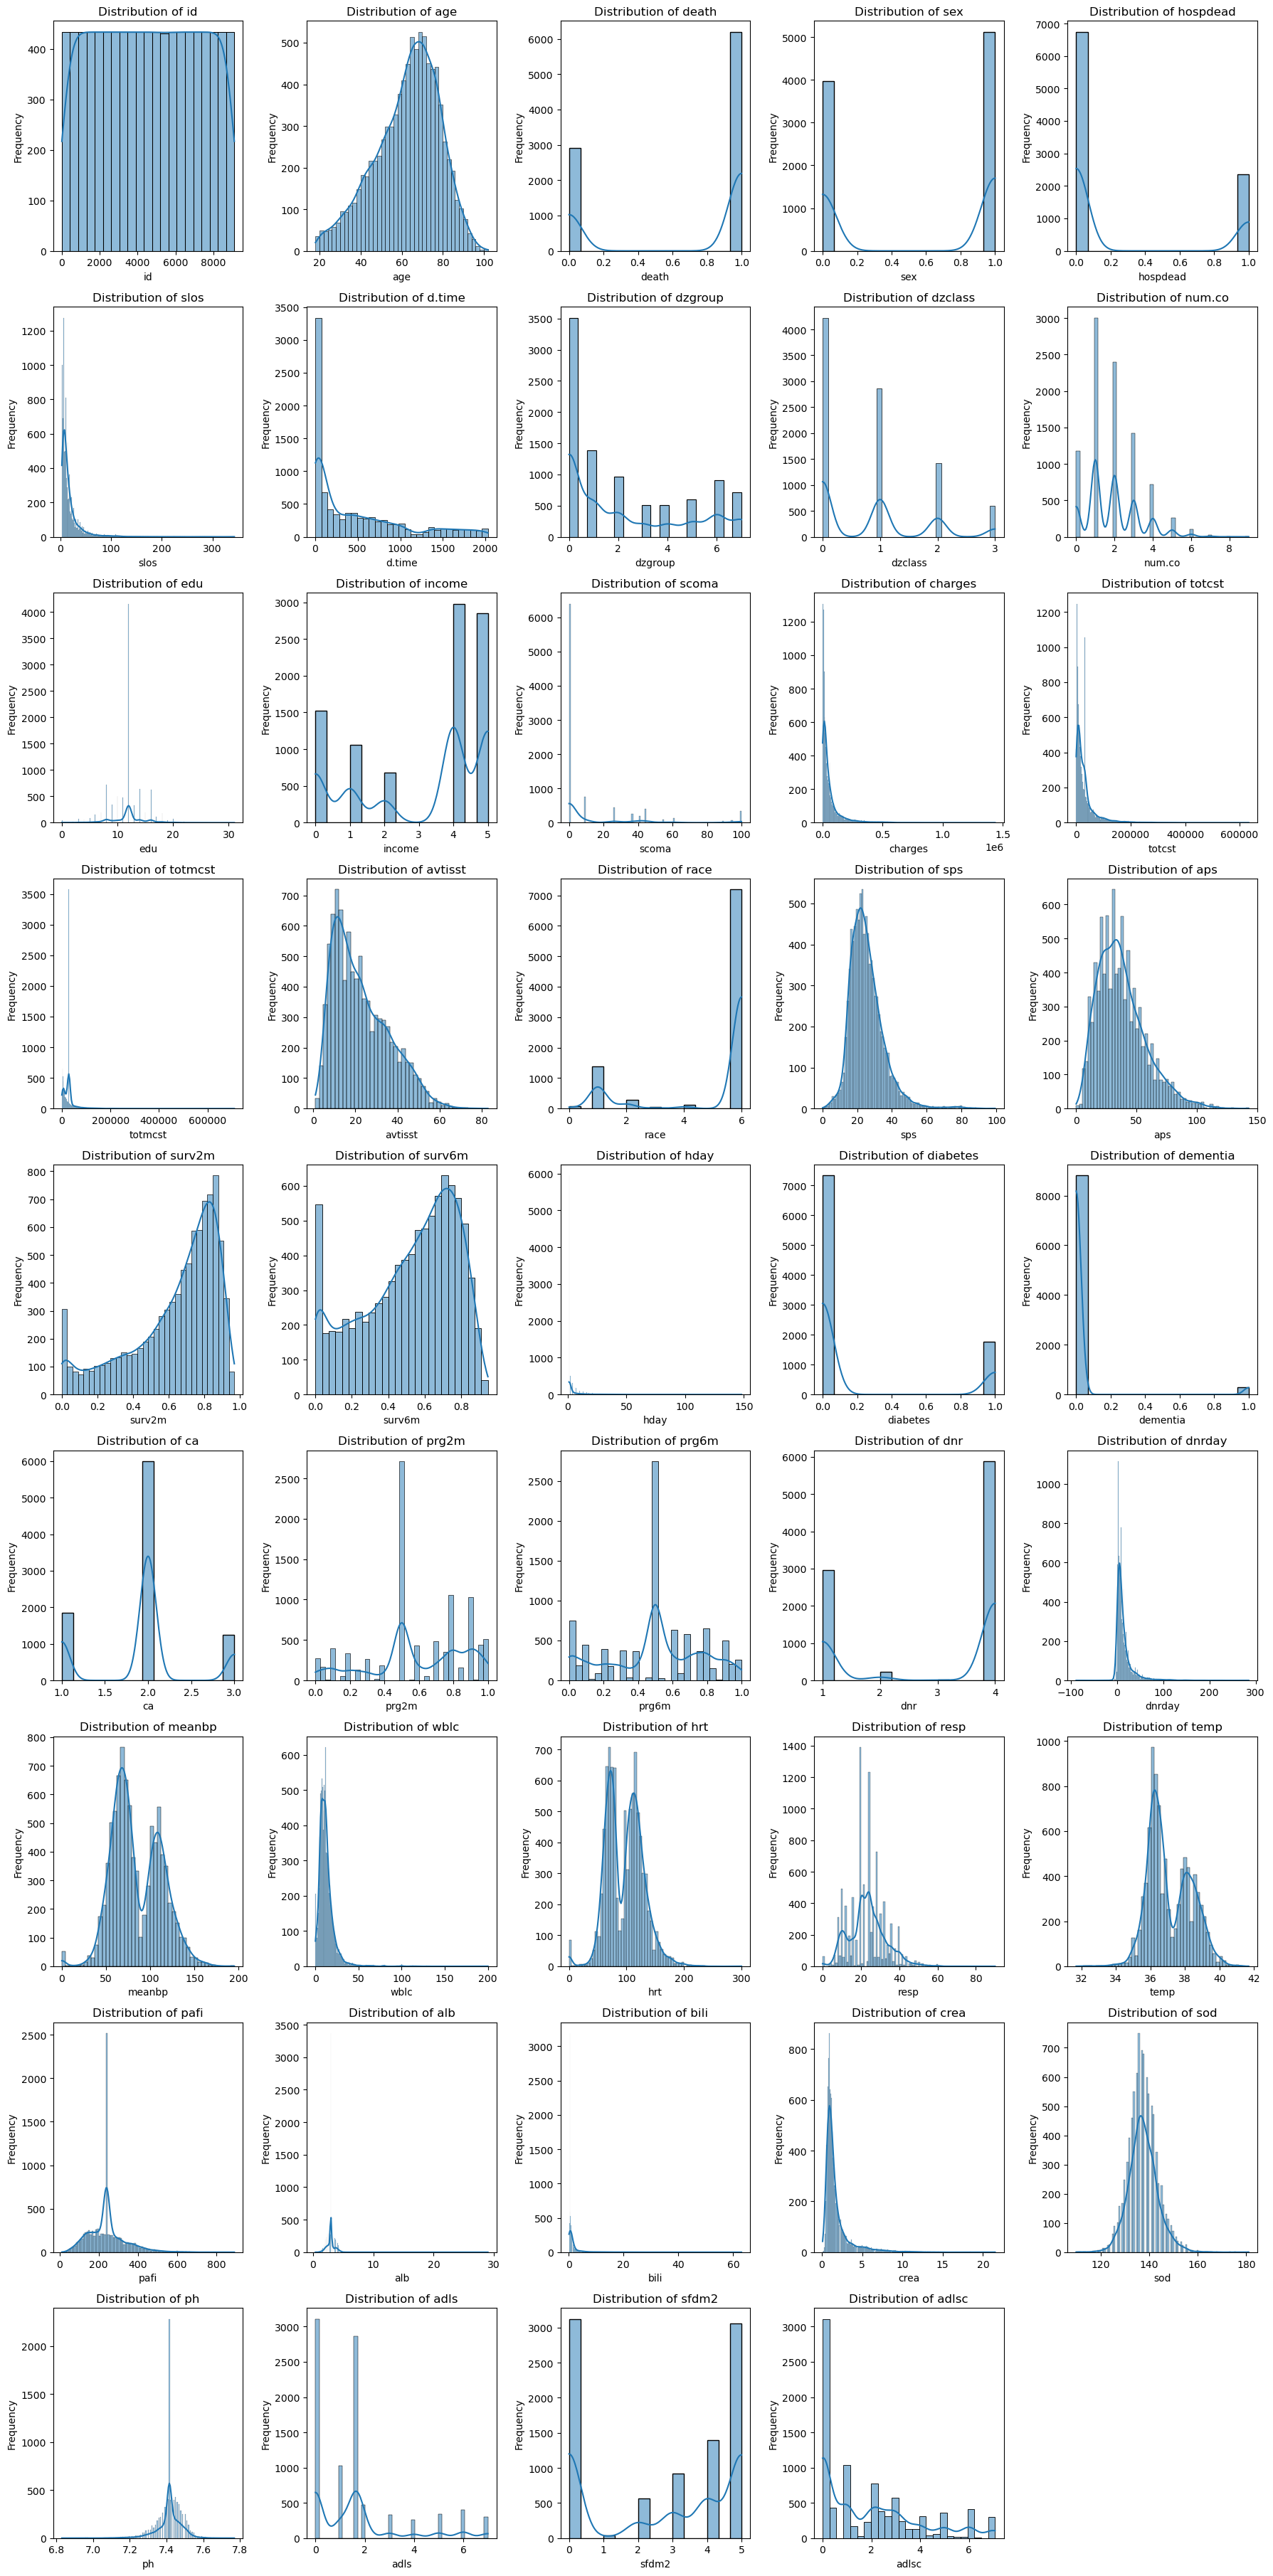

In [34]:
# Load the data from the uploaded file
file_path = './csv/filled_data2.csv'
data = pd.read_csv(file_path)

# Number of columns
num_columns = len(data.columns)

# Set the number of rows and columns for subplots
n_rows = (num_columns // 3) + 1
n_cols = 5

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot histograms for each column
for i, column in enumerate(data.columns):
    sns.histplot(data[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel('Frequency')

# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

หา Outlier ของทุกค่า

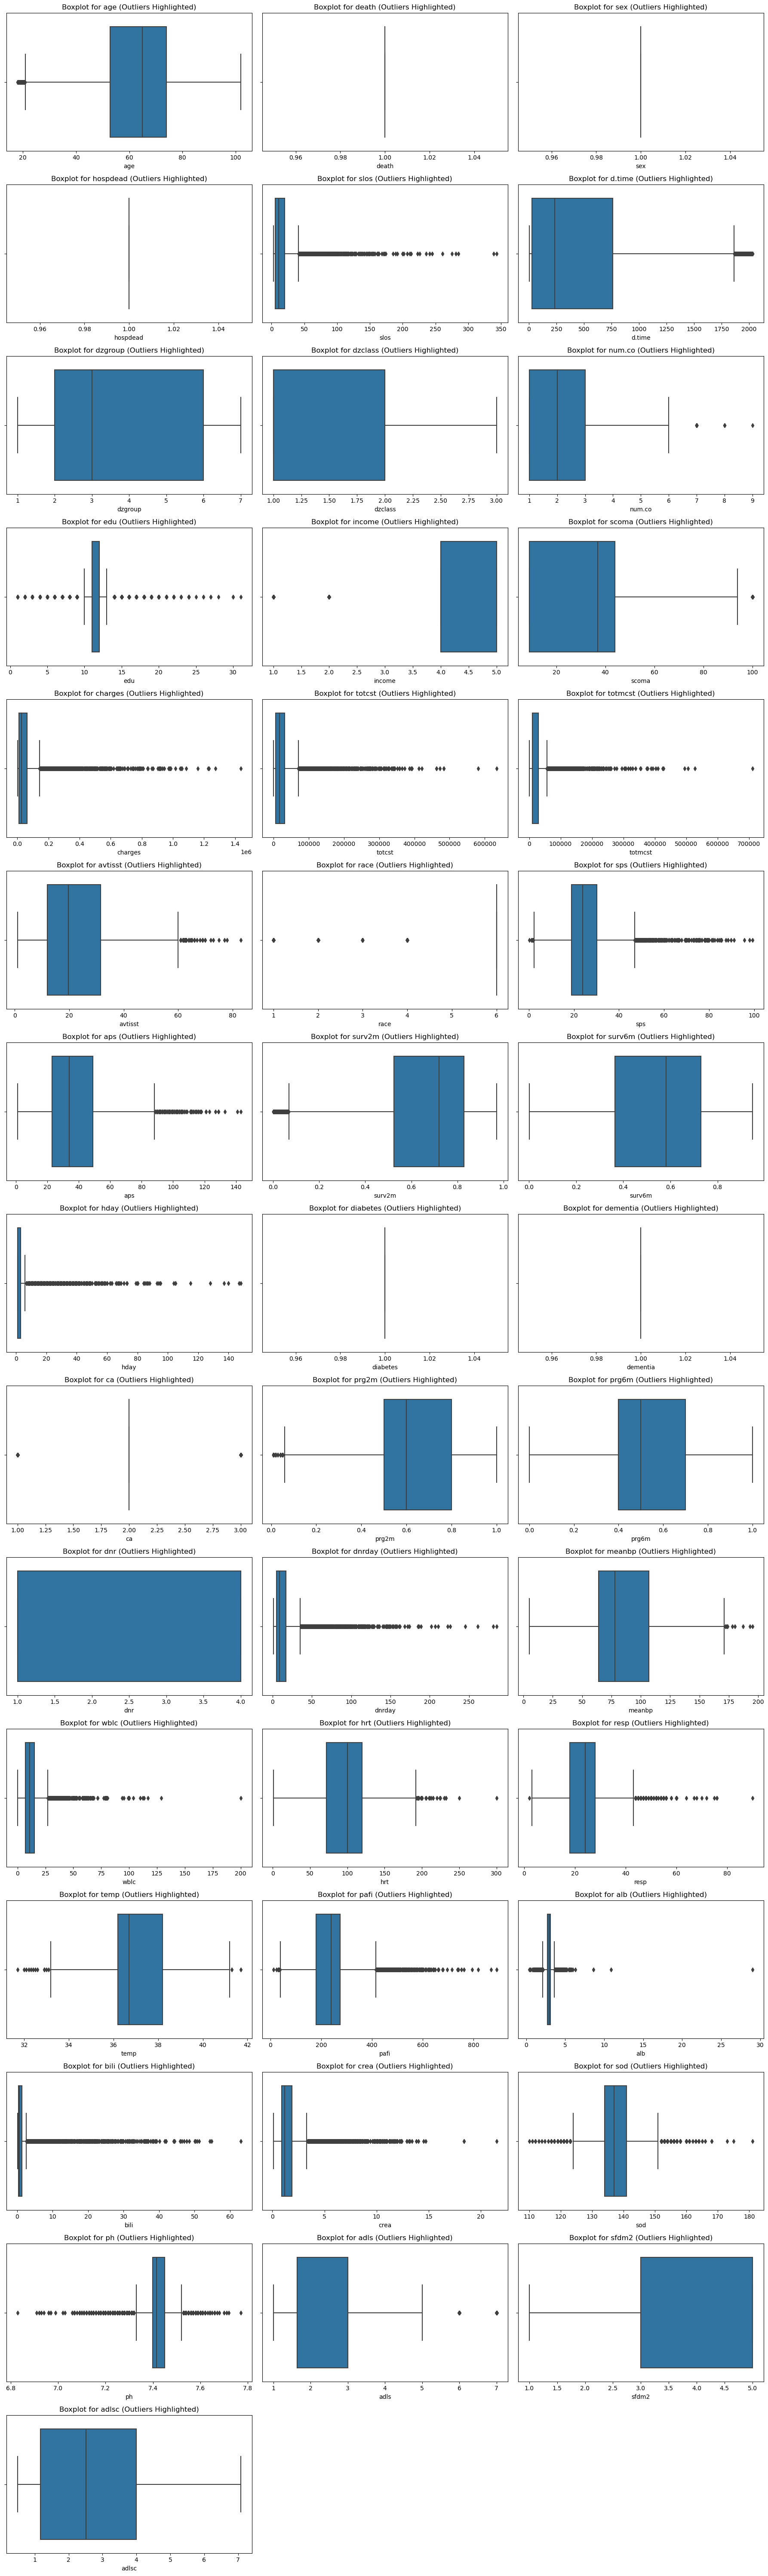

In [35]:
# Columns to apply transformations
columns_to_transform = ['age', 'death', 'sex', 'hospdead', 'slos', 'd.time', 'dzgroup',
       'dzclass', 'num.co', 'edu', 'income', 'scoma', 'charges', 'totcst',
       'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday',
       'diabetes', 'dementia', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday',
       'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea',
       'sod', 'ph', 'adls', 'sfdm2', 'adlsc']

# Function to plot outliers
def plot_outliers(column_data, column_name, ax):
    sns.boxplot(x=column_data, ax=ax)
    ax.set_title(f'Boxplot for {column_name} (Outliers Highlighted)')
    ax.set_xlabel(column_name)

# Set the number of rows and columns for subplots
num_columns = len(columns_to_transform)
n_rows = (num_columns // 3) + 1
n_cols = 3

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Loop through each column and plot outliers
for i, column in enumerate(columns_to_transform):
    if column in data.columns and column != 'id':
        # Filter out non-positive values
        data_filtered = data[data[column] > 0][column]

        if len(data_filtered) > 0:
            # Plot the boxplot for outliers
            plot_outliers(data_filtered, column, axes[i])
        else:
            print(f"Skipping column '{column}' because it has no positive values.")
    else:
        print(f"Column '{column}' not found in the dataset.")

# Remove any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

เอา Outlier ออกจากข้อมูลทั้งหมด แล้วเซฟข้อมูลใหม่ที่ได้

In [46]:
file_path = './csv/filled_data2.csv'
data = pd.read_csv(file_path)

feature_columns = ['id', 'age', 'death', 'sex', 'hospdead', 'slos', 'd.time', 'dzgroup', 
                   'dzclass', 'num.co', 'edu', 'income', 'scoma', 'charges', 'totcst',
                   'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday',
                   'diabetes', 'dementia', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday',
                   'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea',
                   'sod', 'ph', 'adls', 'sfdm2', 'adlsc']

numeric_columns = data[feature_columns].select_dtypes(include=['int64', 'float64']).columns.tolist()
outlier_columns = numeric_columns.copy()
df_std = data.copy()

print("Standard Deviation-based Method")
for column in outlier_columns:
    mean = df_std[column].mean()
    std_dev = df_std[column].std()
    
    min_border = mean - 3 * std_dev
    max_border = mean + 3 * std_dev
    
    # ระบุแถวที่มีค่าเป็น Outliers
    outliers = df_std[(df_std[column] < min_border) | (df_std[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in column '{column}'")
    
    # ลบแถวที่เป็น Outliers
    output = df_std.drop(outliers, inplace=True)

print("\nจำนวนแถวหลังจากลบ Outliers ด้วยวิธี Standard Deviation:", df_std.shape)

# บันทึกผลลัพธ์ลงในไฟล์ CSV
output_file = 'filled_no_outliner.csv'
df_std.to_csv(output_file, index=False)
shutil.move('filled_no_outliner.csv', 'csv')
print(f"\nResults saved to {output_file}")

Standard Deviation-based Method
0 outliers detected in column 'id'
0 outliers detected in column 'age'
0 outliers detected in column 'death'
0 outliers detected in column 'sex'
0 outliers detected in column 'hospdead'
204 outliers detected in column 'slos'
0 outliers detected in column 'd.time'
0 outliers detected in column 'dzgroup'
0 outliers detected in column 'dzclass'
123 outliers detected in column 'num.co'
108 outliers detected in column 'edu'
0 outliers detected in column 'income'
433 outliers detected in column 'scoma'
167 outliers detected in column 'charges'
194 outliers detected in column 'totcst'
178 outliers detected in column 'totmcst'
59 outliers detected in column 'avtisst'
0 outliers detected in column 'race'
79 outliers detected in column 'sps'
61 outliers detected in column 'aps'
86 outliers detected in column 'surv2m'
0 outliers detected in column 'surv6m'
192 outliers detected in column 'hday'
0 outliers detected in column 'diabetes'
233 outliers detected in colum

Plot Histrogram graph(with Outliner) VS Histrogram graph(without Outliner)

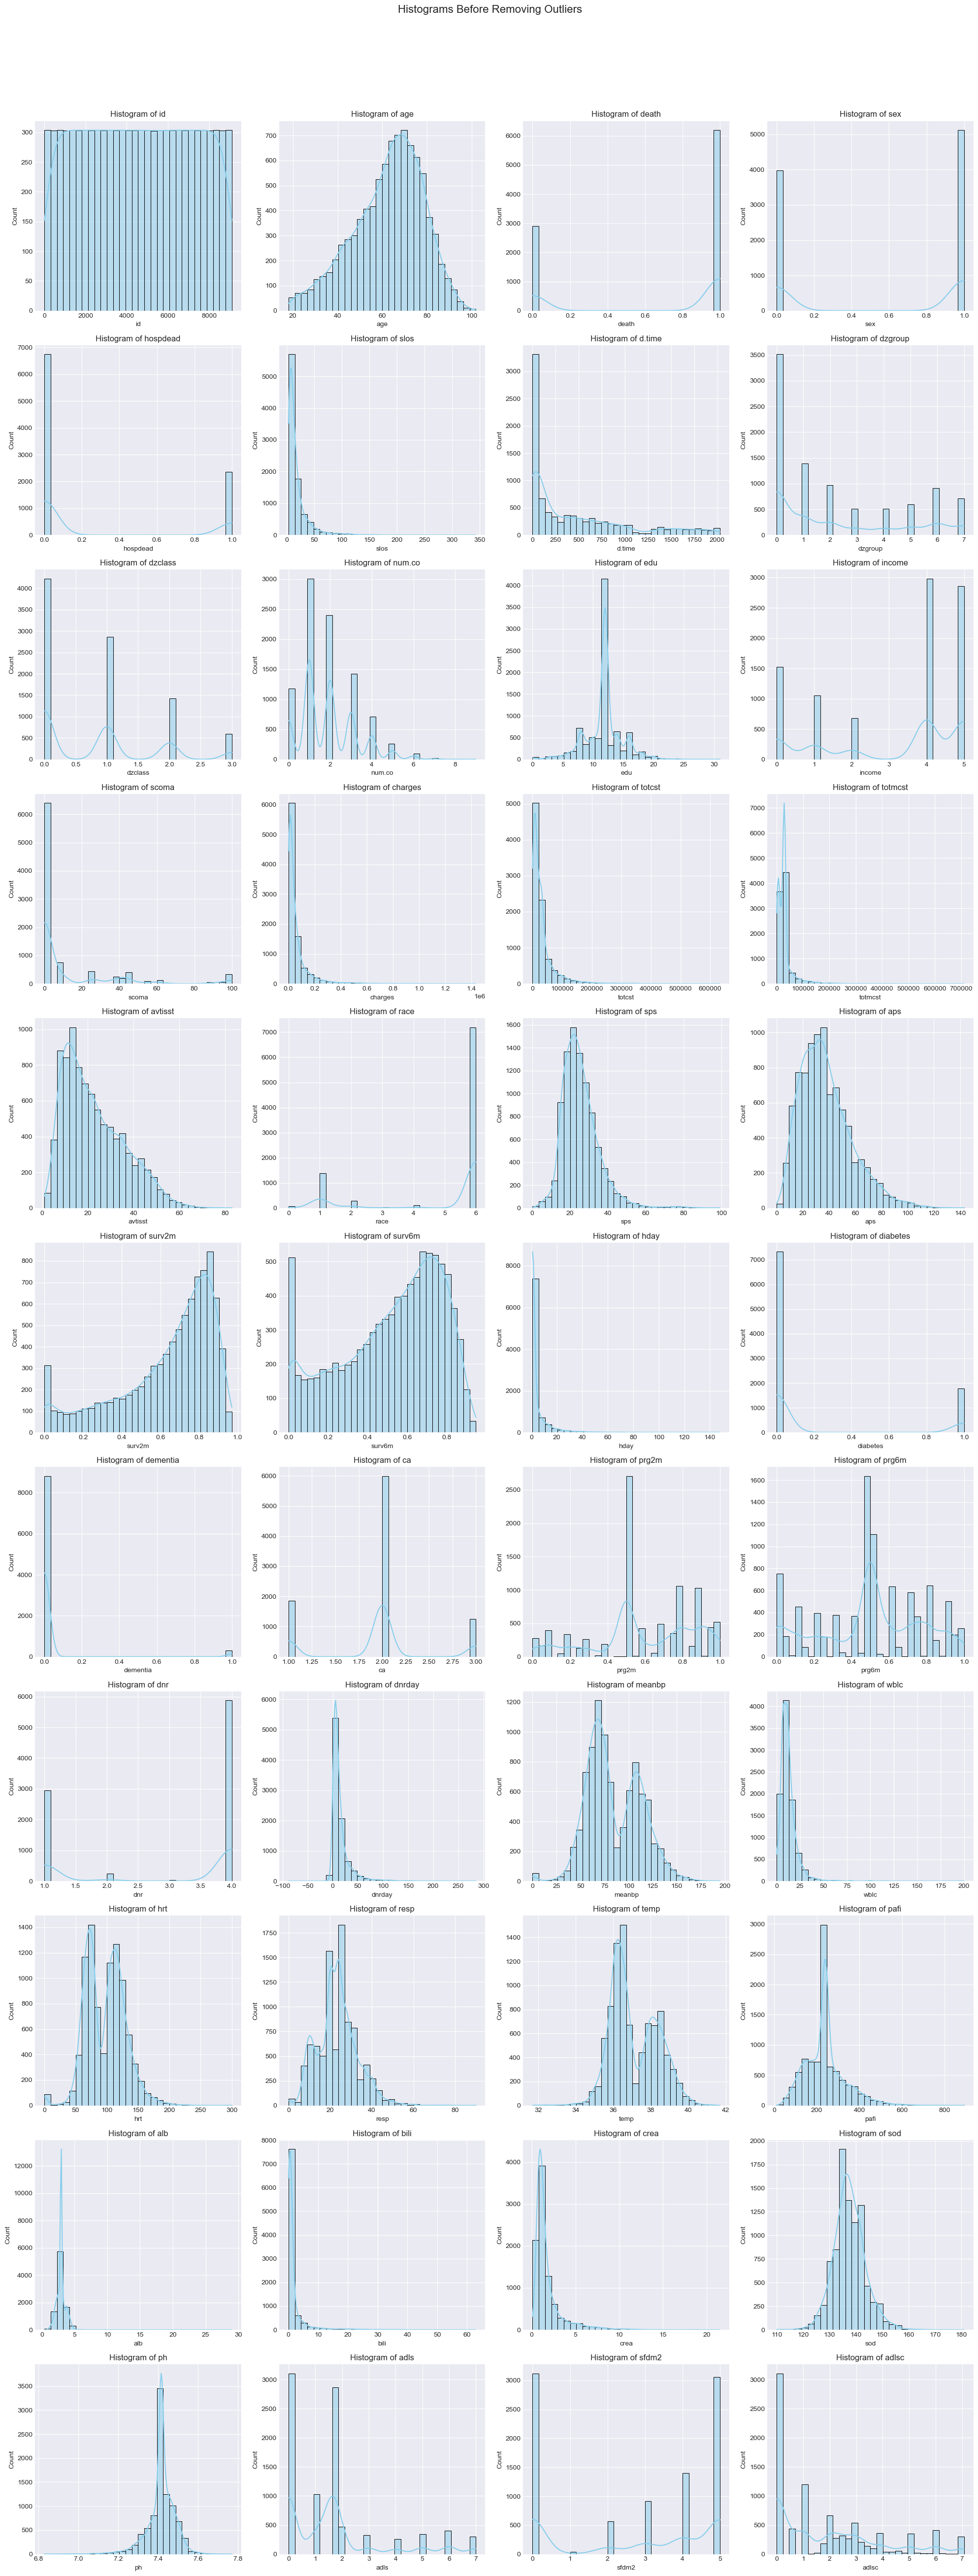

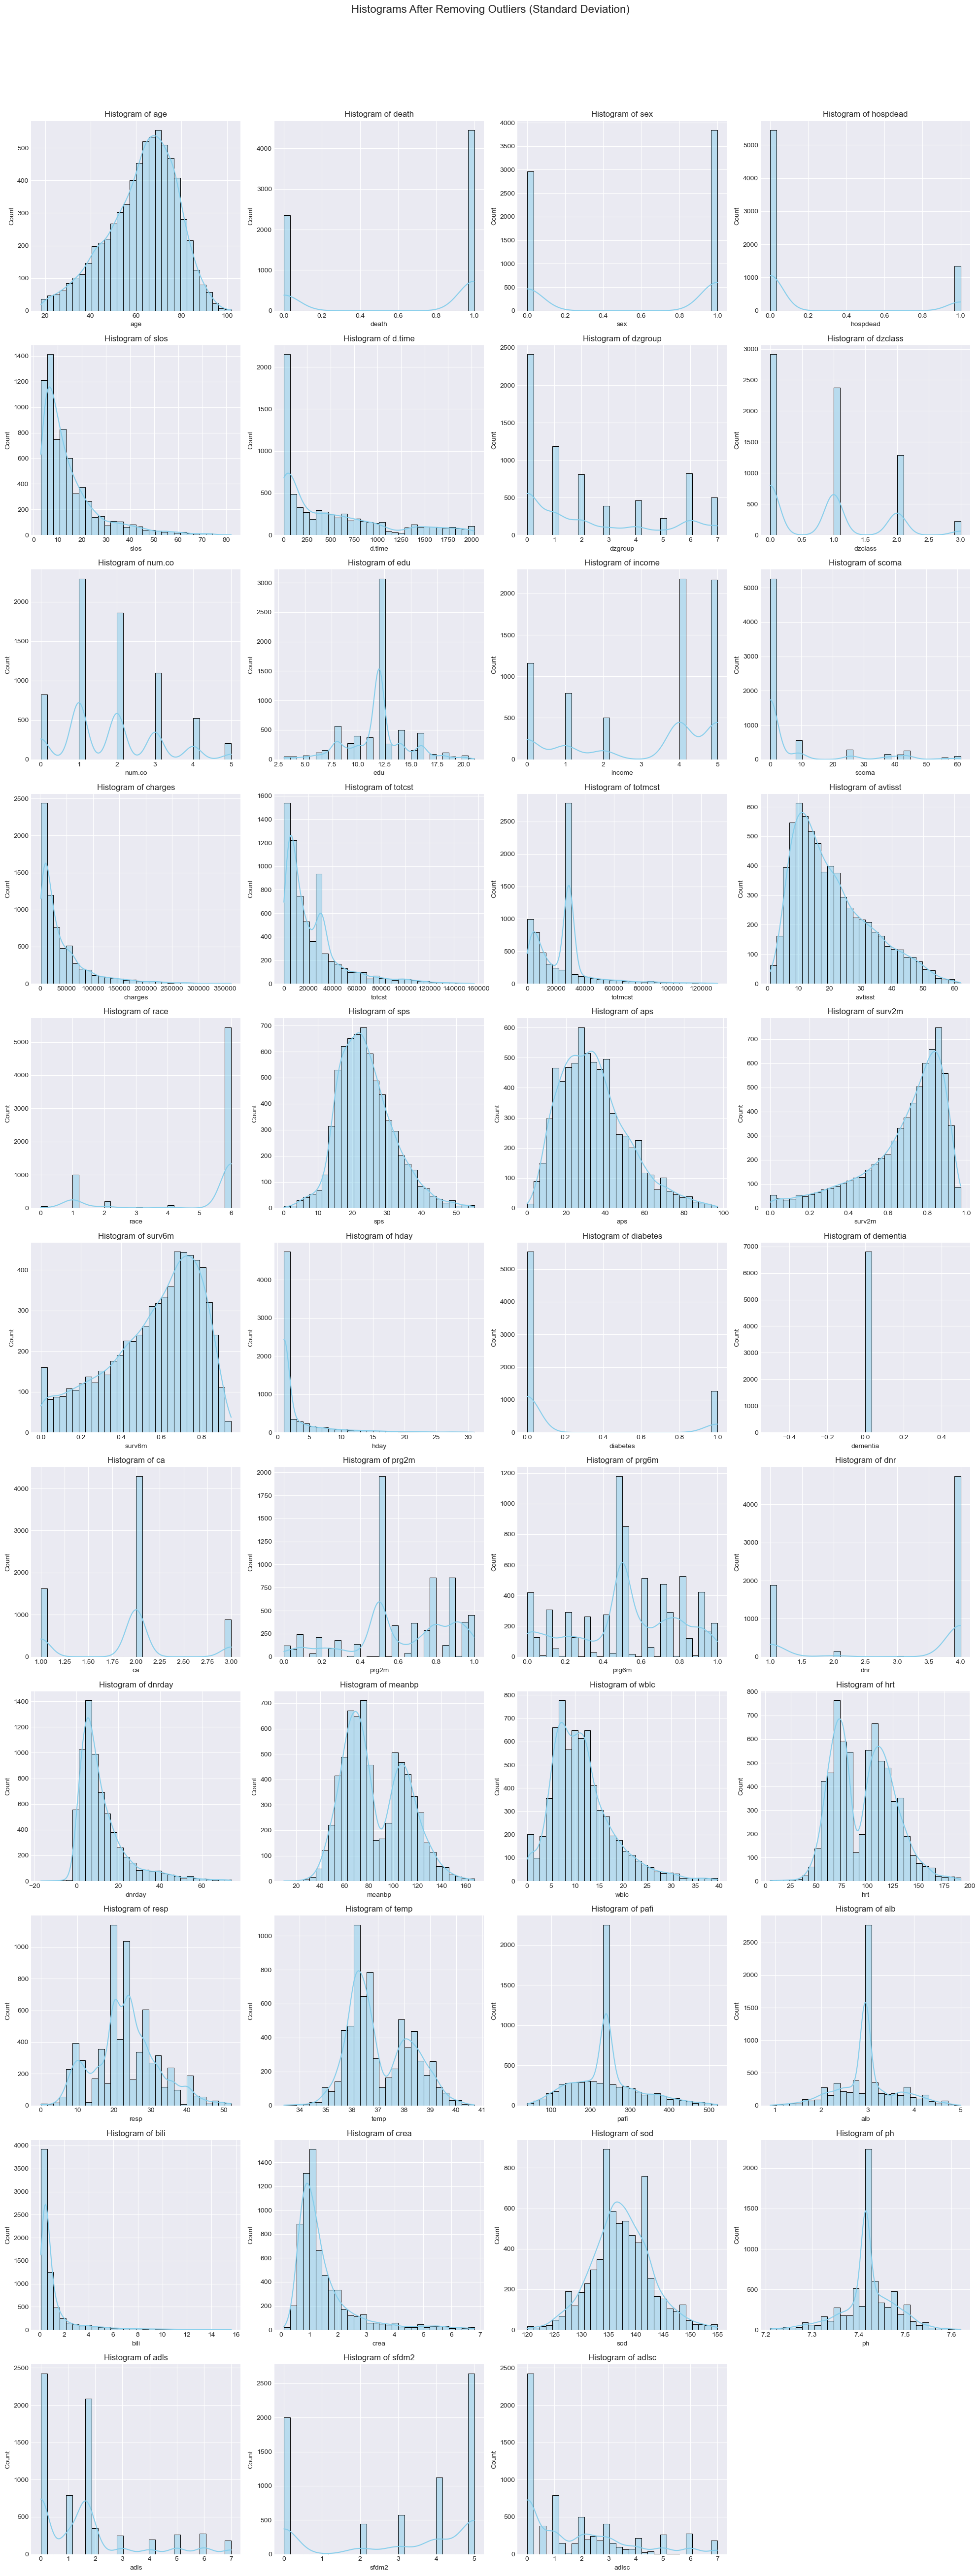

In [61]:
#Folder for save graph 
plots_dir = './csv/plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Histogram Plot 
def plot_histograms(df, columns, title, filename):
    num_cols = len(columns)
    num_rows = (num_cols // 4) + (num_cols % 4 > 0)  # แสดง 4 กราฟต่อแถว
    plt.figure(figsize=(20, 5 * num_rows))
    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, 4, i)
        sns.histplot(df[column], kde=True, bins=30, color='skyblue')
        plt.title(f'Histogram of {column}')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(plots_dir, filename))
    plt.show()

#Plot Histogram with Outliers
plot_histograms(data, numeric_columns, "Histograms Before Removing Outliers", 'hist_before_outlier_removal.png')

#Plot Histogram without Outliers
plot_histograms(df_std, outlier_columns, "Histograms After Removing Outliers (Standard Deviation)", 'hist_after_std_outlier_removal.png')



Normalize Distribuition : ทำให้ข้อมูลทุกอย่างอยู่ในช่วงเดียวกันเพื่อสามารถเปรียบเทียบกันได้


--- Column: age ---
Best transformation for age: Box-Cox (Skewness: -0.09)

--- Column: slos ---
Best transformation for slos: Box-Cox (Skewness: 0.02)

--- Column: d.time ---
Best transformation for d.time: Box-Cox (Skewness: -0.17)

--- Column: dzgroup ---
Best transformation for dzgroup: Square Root (Skewness: 0.02)

--- Column: dzclass ---
Best transformation for dzclass: Log (Skewness: -0.00)

--- Column: num.co ---
Best transformation for num.co: Log (Skewness: -0.44)

--- Column: edu ---
Best transformation for edu: Box-Cox (Skewness: 0.09)

--- Column: income ---
Best transformation for income: Log (Skewness: -0.98)

--- Column: scoma ---
Best transformation for scoma: Log (Skewness: 1.73)

--- Column: charges ---
Best transformation for charges: Box-Cox (Skewness: 0.01)

--- Column: totcst ---
Best transformation for totcst: Square Root (Skewness: 0.68)

--- Column: totmcst ---
Best transformation for totmcst: Square Root (Skewness: -0.27)

--- Column: avtisst ---
Best transf

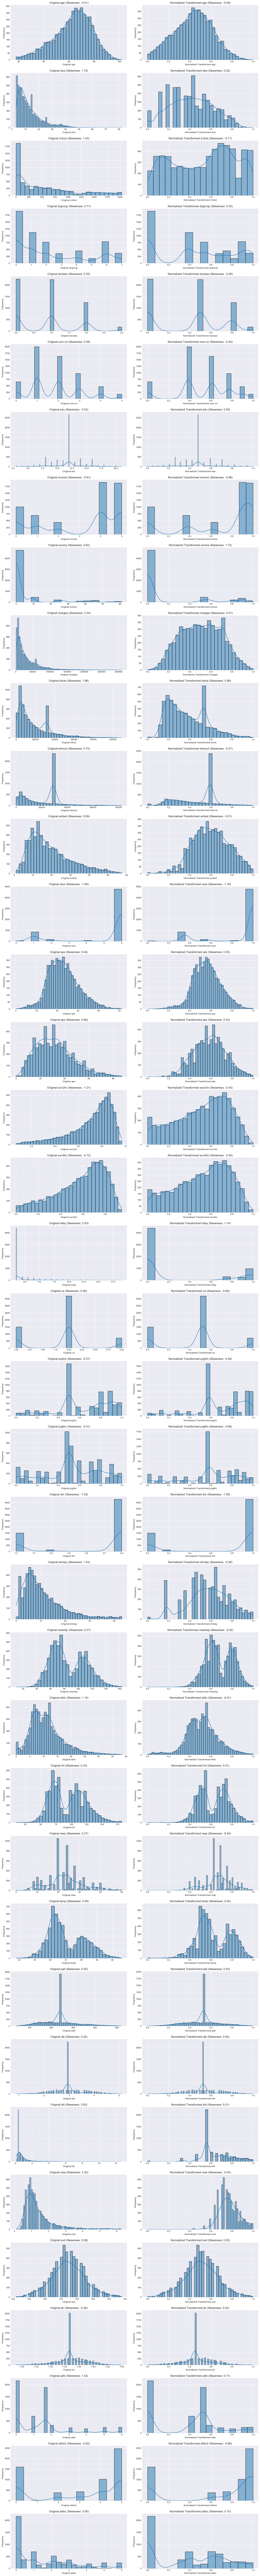

Normalized data saved to ./csv/normalized_data.csv


In [74]:
file_path = './csv/filled_no_outliner.csv'
data = pd.read_csv(file_path)

columns_to_transform = ['age', 'slos', 'd.time', 'dzgroup', 
                        'dzclass', 'num.co', 'edu', 'income', 'scoma', 'charges', 'totcst',
                        'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday',
                        'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday',
                        'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea',
                        'sod', 'ph', 'adls', 'sfdm2', 'adlsc']

# ฟังก์ชันในการประเมิน skewness และ plot
def plot_and_evaluate(column_data, title, ax):
    skewness = column_data.skew()
    sns.histplot(column_data.dropna(), kde=True, ax=ax)
    ax.set_title(f'{title} (Skewness: {skewness:.2f})')
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')
    return skewness

# สร้าง MinMaxScaler เพื่อ Normalize ข้อมูลให้อยู่ในช่วง 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# ฟังก์ชันในการ Normalize ข้อมูล (min-max scaling)
def normalize(column_data):
    # fit_transform ข้อมูลโดยใช้ MinMaxScaler โดยข้ามค่า NaN
    normalized = scaler.fit_transform(column_data.values.reshape(-1, 1))
    # แปลงกลับเป็น 1D (flatten) และคืนค่าเป็น pandas Series พร้อมกับ index เดิม
    return pd.Series(normalized.flatten(), index=column_data.index)

# เตรียม Dictionary เพื่อเก็บข้อมูลที่ Normalize แล้ว
normalized_data_dict = {}

# ตั้งค่า grid ของ subplots
rows = len(columns_to_transform)
fig, axes = plt.subplots(rows, 2, figsize=(16, 4 * rows))
fig.tight_layout(pad=4.0)

# วนลูปผ่านแต่ละคอลัมน์และทำการแปลง
for i, column in enumerate(columns_to_transform):
    if column in data.columns and column != 'id':
        print(f"\n--- Column: {column} ---")
        
        column_data = data[column].copy()
        
        mask = column_data >= 0
        
        if mask.any():
            # Plot ข้อมูลต้นฉบับ
            ax_original = axes[i, 0]
            plot_and_evaluate(column_data[mask], f'Original {column}', ax_original)
            
            # ทำการแปลงต่างๆ
            log_transformed_data = pd.Series(np.log1p(column_data[mask]), index=column_data[mask].index)
            sqrt_transformed_data = pd.Series(np.sqrt(column_data[mask]), index=column_data[mask].index)
            
            # Box-Cox ต้องการค่ามากกว่า 0
            try:
                boxcox_transformed_data, _ = stats.boxcox(column_data[mask])
                boxcox_transformed_data = pd.Series(boxcox_transformed_data, index=column_data[mask].index)
                boxcox_skewness = boxcox_transformed_data.skew()
            except ValueError:
                boxcox_transformed_data = pd.Series(np.nan, index=column_data[mask].index)
                boxcox_skewness = np.nan
            
            # คำนวณ skewness สำหรับแต่ละการแปลง
            skew_log = log_transformed_data.skew()
            skew_sqrt = sqrt_transformed_data.skew()
            skew_boxcox = boxcox_skewness
            
            skewness_values = {
                'Log': skew_log,
                'Square Root': skew_sqrt,
                'Box-Cox': skew_boxcox
            }
            
            # เลือกการแปลงที่ skewness ใกล้เคียงกับ 0 มากที่สุด
            best_transformation = min(
                [k for k in skewness_values if not np.isnan(skewness_values[k])],
                key=lambda k: abs(skewness_values[k])
            )
            
            print(f"Best transformation for {column}: {best_transformation} (Skewness: {skewness_values[best_transformation]:.2f})")
            
            # เลือกข้อมูลที่ถูกแปลงดีที่สุด
            if best_transformation == 'Log':
                best_transformed_data = log_transformed_data
            elif best_transformation == 'Square Root':
                best_transformed_data = sqrt_transformed_data
            elif best_transformation == 'Box-Cox':
                best_transformed_data = boxcox_transformed_data
            
            # สร้าง Series สำหรับการแปลงทั้งหมด โดยแทนที่เฉพาะค่าที่มากกว่า 0
            transformed_full = pd.Series(np.nan, index=column_data.index)
            transformed_full[mask] = best_transformed_data
            
            # Normalize ข้อมูลที่แปลงแล้ว
            normalized_data = normalize(transformed_full)
            normalized_data_dict[column] = normalized_data
            
            # Plot ข้อมูลที่ Normalize แล้ว
            ax_norm = axes[i, 1]
            plot_and_evaluate(normalized_data, f'Normalized Transformed {column}', ax_norm)
        
        else:
            print(f"Skipping column '{column}' because it has no positive values.")
    else:
        print(f"Column '{column}' not found in the dataset.")

plt.show()

# สร้าง DataFrame จาก normalized_data_dict
normalized_df = pd.DataFrame(normalized_data_dict)

# รวมข้อมูลที่ Normalize แล้วกับข้อมูลที่ไม่ได้แปลง
# ใช้ pd.concat เพื่อรวมตาม columns (axis=1) โดยไม่ต้อง drop คอลัมน์ต้นฉบับ
# แต่แทนที่คอลัมน์ต้นฉบับด้วยค่าที่ Normalize แล้ว
final_data = data.copy()
for column in normalized_data_dict:
    final_data[column] = normalized_df[column]

# บันทึกข้อมูลที่ได้ลงในไฟล์ CSV ใหม่
output_file_path = './csv/normalized_data.csv'
final_data.to_csv(output_file_path, index=False)

print(f"Normalized data saved to {output_file_path}")


Feature Selection By ANOVA

     Feature     F-Score
3        sex         inf
33      temp         inf
35       alb         inf
37      crea         inf
23  dementia         inf
12     scoma         inf
11    income         inf
41     sfdm2         inf
26     prg6m         inf
34      pafi         inf
17       sps  109.064194
13    totcst   24.570090
30      wblc   23.292145
19    surv2m    9.977164
0         id    9.032947
14   totmcst    8.262642
32      resp    7.143888
15   avtisst    6.152332
1        age    5.048146
31       hrt    3.527155
38       sod    2.564486
9     num.co    2.548227
7    dzgroup    2.212623
20    surv6m    2.011053
29    meanbp    1.977320
6     d.time    1.582595
36      bili    1.305285
10       edu    0.889294
25     prg2m    0.813018
24        ca    0.699304
8    dzclass    0.668079
18       aps    0.403886
2      death    0.374060
5       slos    0.340689
28    dnrday    0.340689
22  diabetes    0.267675
42     adlsc    0.174406
40      adls    0.094762
39        ph        -inf


c:\Users\anawa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 3  4 11 12 16 21 23 26 27 33 34 35 37 39 41] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\anawa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
c:\Users\anawa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


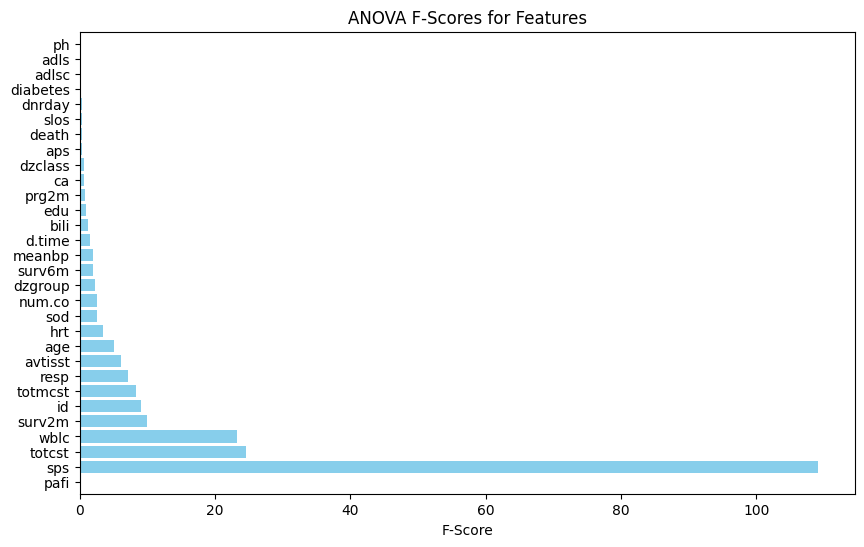

Selected Features based on threshold: ['sps' 'totcst' 'wblc' 'surv2m' 'id' 'totmcst' 'resp' 'avtisst' 'age'
 'hrt' 'sod' 'num.co' 'dzgroup' 'surv6m' 'meanbp' 'd.time' 'bili' 'edu'
 'prg2m' 'ca' 'dzclass' 'aps' 'death' 'slos' 'dnrday' 'diabetes' 'adlsc'
 'adls']
           sps        totcst       wblc    surv2m      id       totmcst  resp  \
0    20.097656  30825.867768   9.099609  0.698975     4.0  28828.877838  32.0   
1    14.599609  30825.867768  10.898438  0.935913    11.0  28828.877838  24.0   
2     7.799805  30825.867768  15.898438  0.856934    16.0  28828.877838  20.0   
3     5.599609  30825.867768   5.000000  0.868896    21.0  28828.877838  20.0   
4    25.398438   5144.718800  10.199219  0.653931    86.0  28828.877838  18.0   
..         ...           ...        ...       ...     ...           ...   ...   
263  20.898438   8675.648400   7.599609  0.618896  8975.0   8634.398440  22.0   
264  25.000000  13563.882800   1.000000  0.791992  9030.0  12909.929700  20.0   
265  26.3

In [10]:
file_path = './csv/normalize-data.csv'
df = pd.read_csv(file_path)

# Step 2: Separate the features (X) and target (y)
X = df.drop(columns=['charges'])  # replace 'target_column' with the actual target column name
y = df['charges']

# Step 3: Apply ANOVA F-test for feature selection
# Use SelectKBest to select top K features based on ANOVA F-scores
k = 10  # Adjust K to select the number of top features you want
selector = SelectKBest(score_func=f_classif, k=k)

# Fit the selector to the data
X_selected = selector.fit_transform(X, y)

# Get the scores of each feature
scores = selector.scores_

# Step 4: Display and visualize feature scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'F-Score': scores})
feature_scores = feature_scores.sort_values(by='F-Score', ascending=False)
print(feature_scores)

# Plot the F-scores
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['F-Score'], color='skyblue')
plt.xlabel('F-Score')
plt.title('ANOVA F-Scores for Features')
plt.show()

# Step 5: Select features based on F-score (Optional: set threshold)
threshold = 0  # Set a threshold for F-score (optional)
selected_features = feature_scores[np.isfinite(feature_scores['F-Score']) & (feature_scores['F-Score'] > threshold)]['Feature']
print(f'Selected Features based on threshold: {selected_features.values}')

# Filter the original dataset to keep only the selected features
X_selected = X[selected_features]

print(X_selected)


Linear Regression หาค่า Random_state ที่ทำให้ค่า MSE ต่ำที่สุด

ปรับ Ramdom state เพื่อหา state ที่ดีที่สุดในการ train model ซึ่งได้ออกมาเป็น 173

In [30]:
best_random_state = None
lowest_mse = float('inf')  # Set to infinity to start
mse_scores = []

random_state_range = range(1, 201)


# ปรับ Ramdom state เพื่อหา state ที่ดีที่สุดในการ train model ซึ่งได้ออกมาเป็น 173

# for random_state in random_state_range:
#     X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=random_state)

#     # Train the model
#     model = LinearRegression()
#     model.fit(X_train, y_train)

#     # Step 7: Make predictions and evaluate the model
#     y_pred = model.predict(X_test)

#     # Evaluate the model performance
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     mse_scores.append((random_state, mse))

#     if mse < lowest_mse:
#         lowest_mse = mse
#         best_random_state = random_state

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=173)
    
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 7: Make predictions and evaluate the model
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Random State: {best_random_state}')
print(f'Lowest MSE: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Optionally, display all MSE values for each random state
mse_scores_df = pd.DataFrame(mse_scores, columns=['Random State', 'MSE'])


Best Random State: None
Lowest MSE: 6801791.189990192
R-squared: 0.7404889248598588


Error plot test vs predict

In [ ]:
target_name = 'charges'
for feature_name in X_selected:
    plt.figure(figsize=(10, 6))

    # Scatter plot of the selected feature vs. actual target values
    plt.scatter(X_test[feature_name], y_test, label='Actual', color='blue', alpha=0.6)

    # Scatter plot of the selected feature vs. predicted target values
    plt.scatter(X_test[feature_name], y_pred, label='Predicted', color='red', alpha=0.6)

    plt.xlabel(feature_name)
    plt.ylabel('Target')
    plt.title(f'{target_name} vs {feature_name} (Actual vs Predicted)')
    plt.legend()
    plt.show()

How is accuracy?

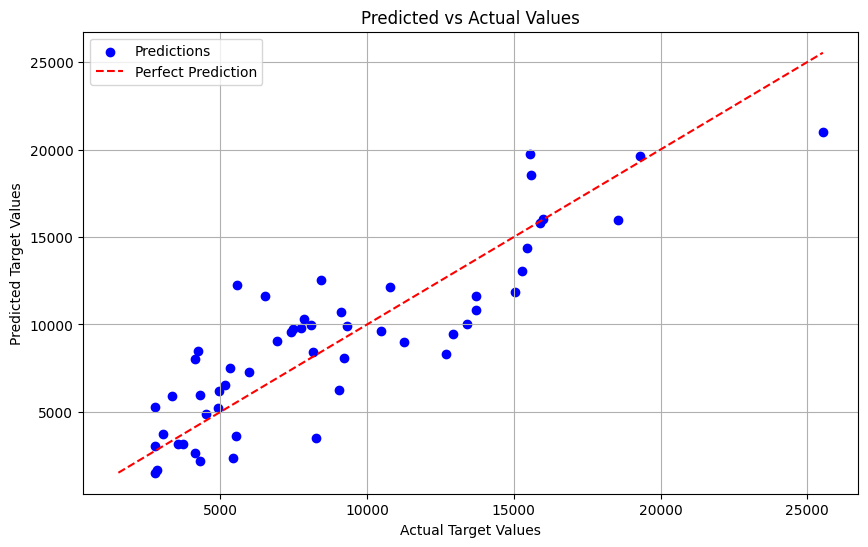

In [31]:
# Plot true values vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')

# Plot a 45-degree line (perfect predictions)
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()